In [79]:
import mne 
import os
import mne 
from mne.io import  read_raw_edf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


In [3]:
data_folder ='data/'

In [68]:
256*5

1280

In [ ]:
folder_list =1
folder_name = f'chb{folder_list:02d}'
file_path = os.path.join(data_folder,folder_name)
edf_files = sorted([f for f in os.listdir(file_path) if f.endswith('.edf')])
first_file_path = os.path.join(file_path, edf_files[0])
raw = mne.io.read_raw_edf(first_file_path, preload=False, verbose="ERROR")
raw2 = raw.compute_psd()
raw2_df = raw2.to_data_frame()
raw2_df.head()



In [42]:
data_folder = "data/"
freq = 128
q = 256/freq

# Set the path to the patient folder
data_files = sorted([f for f in os.listdir(data_folder) if f.startswith('chb')])
# Define the list of channels to keep
#channels_to_keep = ['FP1-F7', 'FP1-F3']# 
dataframes = []  # List to store individual DataFrames

for folder_list in range(1,len(data_files[:2])):  # Assumes folders are named ch01 to ch10
        folder_name = f'chb{folder_list:02d}'  # Format the folder name as ch01, ch02, etc.
        folder_path = os.path.join(data_folder,folder_name)  # Create the full path to the folder

        # Create an empty list to store raw data
        patient_raws = []

        # Create an empty list to store file names
        file_names = []

        # Get a list of .edf files sorted by filename numbers
        edf_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.edf')])

        # Read the first .edf file to obtain the channel information
        first_file_path = os.path.join(folder_path, edf_files[0])
        first_raw = mne.io.read_raw_edf(first_file_path, preload=False, verbose="ERROR")
        #first_raw.pick_channels(channels_to_keep)

        # Loop through the sorted .edf files
        for file in edf_files:
            file_path = os.path.join(folder_path, file)
            raw = mne.io.read_raw_edf(file_path, preload=False, verbose="ERROR")
            #Keep only the specified channels
            #raw.pick_channels(channels_to_keep)
            raw_time_df = raw.to_data_frame()
            new_time = raw_time_df["time"].iloc[::2].reset_index()
            #raw_time_df = raw_time_df["time"]
            raw2 = raw.resample(sfreq=freq)
            raw3 = raw2.compute_psd()

            # Set the channel information for each Raw object to match the first Raw object
            raw3.info = first_raw.info
            raw_df = raw3.to_data_frame()
            raw_df["file_name"] = file
            raw_df["original_time"] = new_time["time"]
            patient_raws.append(raw_df)
            #file_names.extend([file] * len(raw.times))

        # Concatenate the raw objects into a single patient_combined object while maintaining a continuous time axis
        #patient_combined = mne.concatenate_raws(patient_raws, preload=False)
        patient_combined = pd.concat(patient_raws, ignore_index=True)
        # Print info about the combined raw object for this patient
        #print(patient_combined.info)

        #df = patient_combined.to_data_frame()
        #df['file_name'] = file_names
        dataframes.append(patient_combined)
# Concatenate all DataFrames into a single DataFrame
final_dataframe = pd.concat(dataframes, ignore_index=True)

Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window siz

In [43]:
def get_seizure_sequence(source_path="data"):
    all_data = []

    for folder_name in os.listdir(source_path):
        folder_path = os.path.join(source_path, folder_name)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(".txt"):
                    file_path = os.path.join(folder_path, filename)
                    source_file = filename.split("-")[0]
                    data = []
                    current_data = {"File Name": None, "Number of Seizures": None, "Seizure Start Time": np.nan, "Seizure End Time": np.nan, "Source File": source_file}
                    with open(file_path, "r") as file:
                        for line in file:
                            line = line.strip()
                            if line.startswith("File Name:"):
                                current_data = {"File Name": None, "Number of Seizures": None, "Seizure Start Time": np.nan, "Seizure End Time": np.nan, "Source File": source_file}
                                current_data["File Name"] = line.split(": ", 1)[1]
                            elif line.startswith("Number of Seizures in File:"):
                                current_data["Number of Seizures"] = line.split(": ", 1)[1]
                                if current_data["Number of Seizures"] == 0:
                                    data.append(current_data.copy())
                            elif line.startswith("Seizure Start Time:"):
                                current_data["Seizure Start Time"] = int(line.split(": ", 1)[1].split()[0])
                            elif line.startswith("Seizure End Time:"):
                                current_data["Seizure End Time"] = int(line.split(": ", 1)[1].split()[0])
                                data.append(current_data.copy())
                    all_data.extend(data)

    seizure_seq = pd.DataFrame(all_data)
    seizure_seq.columns = seizure_seq.columns.str.lower().str.replace(" ", "_")
    int_columns = seizure_seq.select_dtypes(include=['int64']).columns
    seizure_seq[int_columns] = seizure_seq[int_columns].astype(float)
    seizure_seq["number_of_seizures"] = seizure_seq["number_of_seizures"].astype(int)

    return seizure_seq

In [44]:
final_dataframe.head()

,freq,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,file_name,original_time
0,0.0000,1.926187e-11,9.423722e-12,1.458493e-12,1.155624e-12,1.685263e-11,3.758683e-12,2.536545e-12,1.254932e-12,1.002311e-11,...,1.082402e-11,2.874724e-12,1.555799e-12,1.458493e-12,4.173809e-12,1.518586e-11,4.648132e-12,2.118360e-12,chb01_01.edf,0.000000
1,0.0625,9.757412e-11,5.154334e-11,1.142507e-11,8.410133e-12,8.343285e-11,1.988227e-11,1.428231e-11,6.380225e-12,5.010294e-11,...,6.589556e-11,1.607176e-11,7.678031e-12,1.142507e-11,2.120630e-11,9.596256e-11,2.871864e-11,9.753057e-12,chb01_01.edf,0.007812
2,0.1250,3.247750e-10,1.660509e-10,3.941451e-11,2.496724e-11,2.838240e-10,5.069754e-11,3.029892e-11,2.235177e-11,1.653294e-10,...,1.931171e-10,4.375898e-11,2.097178e-11,3.941451e-11,7.143390e-11,3.057618e-10,9.795765e-11,2.838403e-11,chb01_01.edf,0.015625
3,0.1875,4.999477e-10,3.066554e-10,6.851355e-11,3.806979e-11,4.529772e-10,6.964478e-11,3.744919e-11,4.114464e-11,2.814553e-10,...,3.090122e-10,5.973151e-11,3.666641e-11,6.851355e-11,1.383735e-10,5.581817e-10,1.743326e-10,5.201099e-11,chb01_01.edf,0.023438
4,0.2500,5.929358e-10,4.077963e-10,7.993221e-11,4.331434e-11,5.728772e-10,9.045442e-11,3.794333e-11,5.125719e-11,3.528059e-10,...,4.025653e-10,7.358986e-11,4.934669e-11,7.993221e-11,1.941902e-10,7.463715e-10,2.541675e-10,7.495613e-11,chb01_01.edf,0.031250


In [45]:
seizure_sequences = get_seizure_sequence("data")
seizure_sequences

,file_name,number_of_seizures,seizure_start_time,seizure_end_time,source_file
0,chb03_01.edf,1,362.0,414.0,chb03
1,chb03_02.edf,1,731.0,796.0,chb03
2,chb03_03.edf,1,432.0,501.0,chb03
3,chb03_04.edf,1,2162.0,2214.0,chb03
4,chb03_34.edf,1,1982.0,2029.0,chb03
5,chb03_35.edf,1,2592.0,2656.0,chb03
6,chb03_36.edf,1,1725.0,1778.0,chb03
7,chb05_06.edf,1,417.0,532.0,chb05
8,chb05_13.edf,1,1086.0,1196.0,chb05
9,chb05_16.edf,1,2317.0,2413.0,chb05


In [46]:
# Add the number of seizures per dataframe
merged_df = final_dataframe.merge(seizure_sequences[["file_name", "number_of_seizures"]], on='file_name', how='left')
# Fill NaN values in the new column with 0 (no seizures by default)
merged_df['number_of_seizures'].fillna(0, inplace=True)
merged_df

,freq,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,file_name,original_time,number_of_seizures
0,0.0000,1.926187e-11,9.423722e-12,1.458493e-12,1.155624e-12,1.685263e-11,3.758683e-12,2.536545e-12,1.254932e-12,1.002311e-11,...,2.874724e-12,1.555799e-12,1.458493e-12,4.173809e-12,1.518586e-11,4.648132e-12,2.118360e-12,chb01_01.edf,0.000000,0.0
1,0.0625,9.757412e-11,5.154334e-11,1.142507e-11,8.410133e-12,8.343285e-11,1.988227e-11,1.428231e-11,6.380225e-12,5.010294e-11,...,1.607176e-11,7.678031e-12,1.142507e-11,2.120630e-11,9.596256e-11,2.871864e-11,9.753057e-12,chb01_01.edf,0.007812,0.0
2,0.1250,3.247750e-10,1.660509e-10,3.941451e-11,2.496724e-11,2.838240e-10,5.069754e-11,3.029892e-11,2.235177e-11,1.653294e-10,...,4.375898e-11,2.097178e-11,3.941451e-11,7.143390e-11,3.057618e-10,9.795765e-11,2.838403e-11,chb01_01.edf,0.015625,0.0
3,0.1875,4.999477e-10,3.066554e-10,6.851355e-11,3.806979e-11,4.529772e-10,6.964478e-11,3.744919e-11,4.114464e-11,2.814553e-10,...,5.973151e-11,3.666641e-11,6.851355e-11,1.383735e-10,5.581817e-10,1.743326e-10,5.201099e-11,chb01_01.edf,0.023438,0.0
4,0.2500,5.929358e-10,4.077963e-10,7.993221e-11,4.331434e-11,5.728772e-10,9.045442e-11,3.794333e-11,5.125719e-11,3.528059e-10,...,7.358986e-11,4.934669e-11,7.993221e-11,1.941902e-10,7.463715e-10,2.541675e-10,7.495613e-11,chb01_01.edf,0.031250,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43045,63.7500,2.229347e-13,2.095967e-13,1.169874e-13,7.793158e-15,1.502861e-13,3.026197e-14,4.117459e-14,7.410714e-15,7.285727e-14,...,8.308731e-14,1.300710e-13,1.169874e-13,1.542088e-13,5.657906e-14,7.230617e-14,1.099790e-13,chb01_46.edf,7.968750,0.0
43046,63.8125,2.165669e-13,1.897334e-13,1.133040e-13,7.690601e-15,1.471571e-13,3.501033e-14,3.660022e-14,6.886628e-15,6.287939e-14,...,9.642449e-14,1.439752e-13,1.133040e-13,1.356488e-13,6.288381e-14,8.456598e-14,1.202647e-13,chb01_46.edf,7.976562,0.0
43047,63.8750,2.058879e-13,1.776569e-13,1.416116e-13,9.168101e-15,1.417886e-13,3.949961e-14,3.854261e-14,7.017972e-15,7.458563e-14,...,9.028545e-14,1.388535e-13,1.416116e-13,1.387152e-13,8.326535e-14,9.109230e-14,1.170447e-13,chb01_46.edf,7.984375,0.0
43048,63.9375,2.021586e-13,2.182087e-13,1.194716e-13,1.997248e-14,1.293924e-13,4.205023e-14,3.469502e-14,1.899622e-14,7.492421e-14,...,1.251515e-13,1.800754e-13,1.194716e-13,1.677643e-13,7.634708e-14,8.312064e-14,1.088093e-13,chb01_46.edf,7.992188,0.0


In [47]:
df = merged_df.drop(["freq", "original_time","file_name"], axis =1)

/var/folders/rc/97bvm7z97gd87g90vfhmcrq00000gn/T/ipykernel_28572/2597090072.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 30)


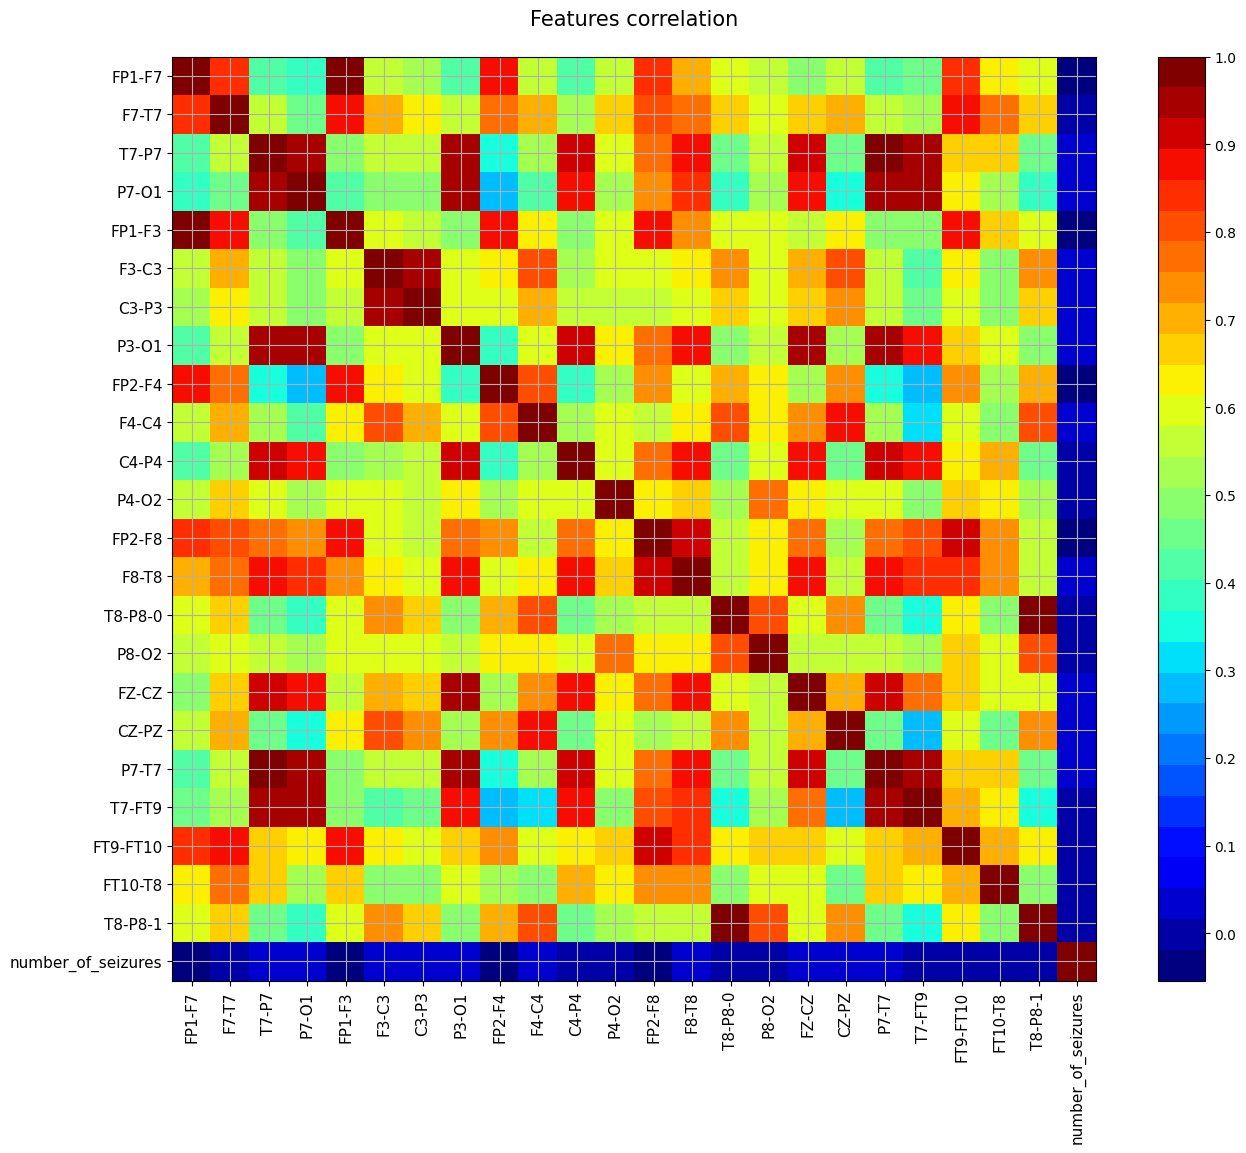

In [13]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Features correlation\n',fontsize=15)
    labels=df.columns
    ax1.set_xticks(np.arange(len(df.columns)))
    ax1.set_xticklabels(labels,fontsize=11, rotation=90)
    ax1.set_yticks(np.arange(len(df.columns)))
    ax1.set_yticklabels(labels,fontsize=11)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.1*i for i in range(-11,11)])
    plt.show()

correlation_matrix(df)

In [48]:
df_nosz= df.drop(["number_of_seizures"], axis =1)

In [49]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_nosz)
df_scaled = pd.DataFrame(data=df_scaled,columns=df_nosz.columns)

In [52]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components=None)
df_pca = pca.fit(df_scaled)

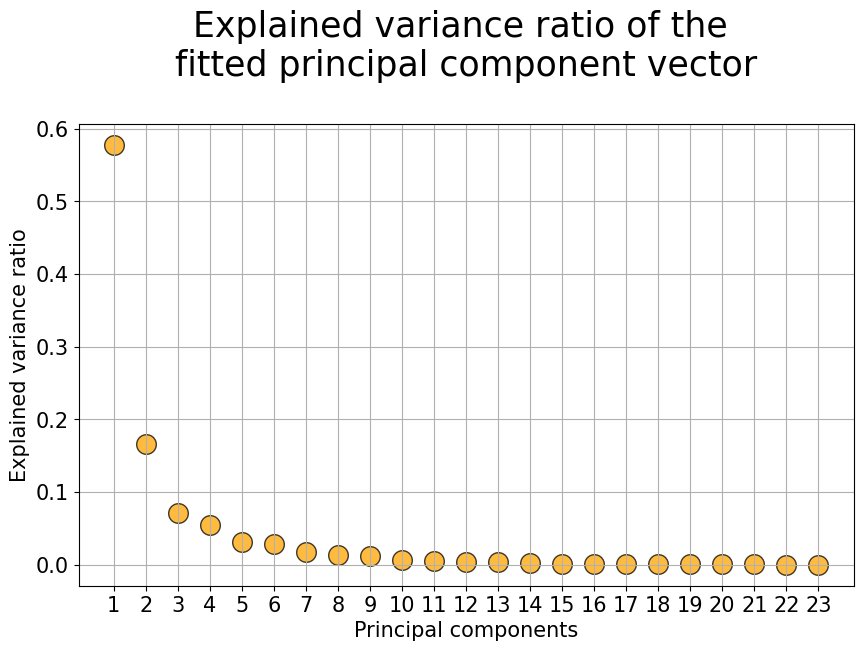

In [64]:
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(df_pca.explained_variance_ratio_))],
            y=df_pca.explained_variance_ratio_,
            s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(df_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [65]:
df_trans = pca.transform(df_scaled)
df_trans = pd.DataFrame(data=df_trans)
df_trans.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.645277,0.221505,0.049087,0.005760,0.014557,0.003279,0.062444,-0.026487,-0.019210,0.007881,...,0.018729,-0.006951,0.005928,-0.011367,-0.013749,0.002797,-0.007833,-0.020263,-5.609183e-18,-5.314857e-17
1,0.045604,-0.058762,0.421398,-0.251971,0.004032,0.128489,0.172261,0.006974,-0.127975,-0.017870,...,0.027736,-0.016564,0.096350,-0.054074,-0.019151,0.030909,-0.047049,-0.052226,-8.909516e-17,-6.981337e-17
2,1.876647,-0.812725,1.578895,-1.027904,-0.015665,0.451026,0.389776,0.159209,-0.400301,-0.034481,...,0.052710,-0.019467,0.308286,-0.188007,0.000569,0.116252,-0.115826,-0.107751,-2.845730e-16,-4.766295e-17
3,3.719209,-1.480067,2.719180,-1.766061,0.013104,0.636658,0.685597,0.503529,-0.787256,0.009489,...,-0.034500,0.091710,0.609274,-0.340723,0.091743,0.196971,-0.134516,-0.097777,-6.193226e-16,-3.053889e-16
4,5.046735,-1.903942,3.480650,-2.318294,0.076343,0.717687,0.973583,0.793016,-1.054821,0.052003,...,-0.085138,0.143434,0.800312,-0.509457,0.079698,0.411916,-0.145314,-0.066602,-5.715769e-16,-2.804553e-16
5,6.267184,-2.483803,4.220843,-3.069222,0.054849,0.931845,0.971895,0.795883,-1.125287,0.062582,...,-0.112317,0.083711,0.893631,-0.575997,0.121108,0.463915,-0.209978,-0.044980,-7.765052e-16,-3.667932e-16
6,7.880190,-3.315640,5.447668,-3.958883,-0.231010,1.142613,0.967067,0.955771,-1.378534,0.255970,...,-0.154785,0.333080,1.122451,-0.664805,0.138304,0.419487,-0.128217,-0.080332,-9.559252e-16,-3.586729e-16
7,8.624114,-3.819268,6.057258,-4.374726,-0.620718,1.178929,0.958941,1.054698,-1.633404,0.439616,...,-0.298591,0.216334,1.744116,-0.986533,0.018324,0.615283,-0.374817,-0.105255,-9.248516e-16,-7.229754e-16
8,8.924761,-3.527494,6.077996,-4.269297,-0.556544,0.856802,1.422332,1.214691,-1.658897,0.538964,...,-0.379314,0.364950,1.550026,-0.789781,0.197616,0.384517,-0.140409,0.050811,-8.510265e-16,-4.003067e-16
9,9.344872,-3.761148,6.266401,-4.504372,-0.613167,0.788075,1.333587,1.305552,-1.832944,0.792655,...,-0.340277,0.691525,1.525585,-0.810167,0.240815,0.379355,0.053973,-0.101182,-8.961437e-16,-5.143357e-16


In [56]:
y= df.number_of_seizures

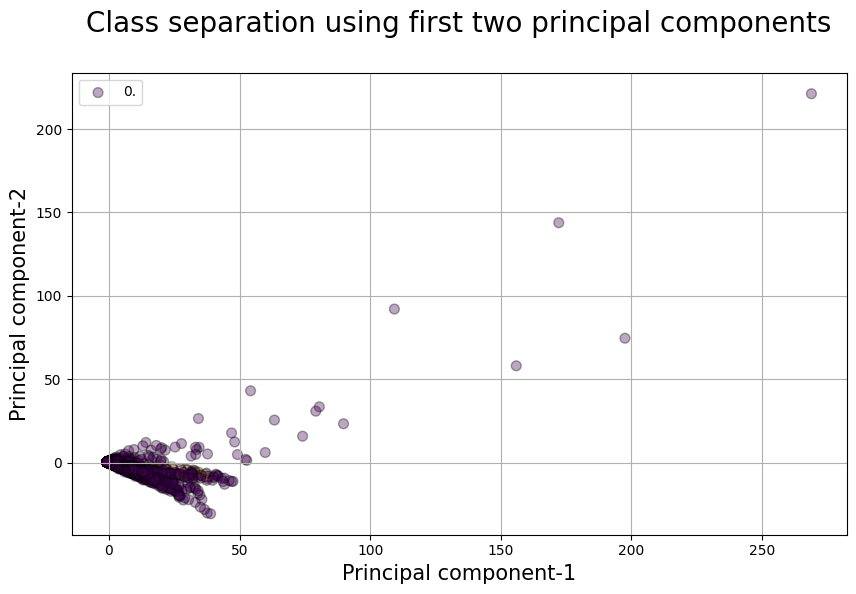

In [66]:
plt.figure(figsize=(10,6))
plt.scatter(df_trans[0],df_trans[1],c=y,edgecolors='k',alpha=0.35,s=50)
classes = ['0.', '1.']
plt.legend(labels=classes)
plt.grid(True)
plt.title("Class separation using first two principal components\n",fontsize=20)
plt.xlabel("Principal component-1",fontsize=15)
plt.ylabel("Principal component-2",fontsize=15)
plt.show()

In [76]:
df.head()

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1,number_of_seizures
0,1.926187e-11,9.423722e-12,1.458493e-12,1.155624e-12,1.685263e-11,3.758683e-12,2.536545e-12,1.254932e-12,1.002311e-11,2.342553e-12,...,2.118360e-12,1.082402e-11,2.874724e-12,1.555799e-12,1.458493e-12,4.173809e-12,1.518586e-11,4.648132e-12,2.118360e-12,0.0
1,9.757412e-11,5.154334e-11,1.142507e-11,8.410133e-12,8.343285e-11,1.988227e-11,1.428231e-11,6.380225e-12,5.010294e-11,1.061018e-11,...,9.753057e-12,6.589556e-11,1.607176e-11,7.678031e-12,1.142507e-11,2.120630e-11,9.596256e-11,2.871864e-11,9.753057e-12,0.0
2,3.247750e-10,1.660509e-10,3.941451e-11,2.496724e-11,2.838240e-10,5.069754e-11,3.029892e-11,2.235177e-11,1.653294e-10,2.760821e-11,...,2.838403e-11,1.931171e-10,4.375898e-11,2.097178e-11,3.941451e-11,7.143390e-11,3.057618e-10,9.795765e-11,2.838403e-11,0.0
3,4.999477e-10,3.066554e-10,6.851355e-11,3.806979e-11,4.529772e-10,6.964478e-11,3.744919e-11,4.114464e-11,2.814553e-10,4.905178e-11,...,5.201099e-11,3.090122e-10,5.973151e-11,3.666641e-11,6.851355e-11,1.383735e-10,5.581817e-10,1.743326e-10,5.201099e-11,0.0
4,5.929358e-10,4.077963e-10,7.993221e-11,4.331434e-11,5.728772e-10,9.045442e-11,3.794333e-11,5.125719e-11,3.528059e-10,6.483495e-11,...,7.495613e-11,4.025653e-10,7.358986e-11,4.934669e-11,7.993221e-11,1.941902e-10,7.463715e-10,2.541675e-10,7.495613e-11,0.0


In [87]:
grouped = df.groupby(['number_of_seizures']).mean().reset_index()
grouped.head()

,number_of_seizures,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
0,0.0,6.205257e-11,2.245394e-11,1.723002e-11,1.553643e-11,6.001303e-11,2.573324e-11,1.960152e-11,2.194468e-11,4.582518e-11,...,2.821259e-11,3.297624e-11,5.021319e-11,3.323669e-11,4.054223e-11,1.723002e-11,1.455473e-11,5.031156e-11,1.741641e-11,3.297624e-11
1,1.0,3.368191e-11,2.084013e-11,2.067367e-11,1.931484e-11,4.088514e-11,3.441110e-11,2.063655e-11,2.736057e-11,3.567691e-11,...,2.770975e-11,3.394071e-11,3.826546e-11,4.293873e-11,4.500797e-11,2.067367e-11,1.234101e-11,4.733389e-11,1.296251e-11,3.394071e-11


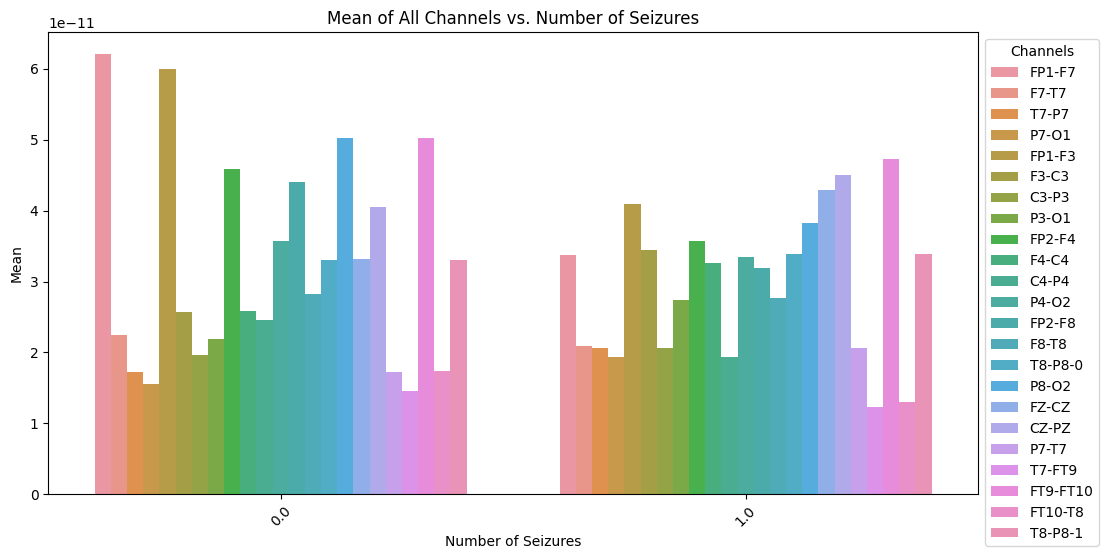

In [88]:
melted_data = pd.melt(grouped, id_vars=['number_of_seizures'],
                      var_name='Channel', value_name='Mean')

# Create a grouped bar plot to visualize means of all channels
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_data, x='number_of_seizures', y='Mean', hue='Channel')
plt.title('Mean of All Channels vs. Number of Seizures')
plt.xlabel('Number of Seizures')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.legend(title='Channels', bbox_to_anchor=(1, 1))
plt.show()